This notebook has several plots of the analysis of the X-SH trajectories for the simulation of the 1D T6-PDI system. I first plot the time-dependent electronic populations of different types of adiabats, averaged over all trajectories. Then I plot the diabats' populations for 5 different groups of trajectories, which were delineated by the XT-characters of the trajectories' initial surface wavefunctions. The two paths at the start specify the paths to the directories that contain the arrays of processed output data. 

For all plots here, you should just be able to switch the directories if you want to plot the same thing, but for a different batch of trajectories. Also, pay attention to the timestep arrays, as I had to specify them more than once, as some of the plots correspond to different trajectory batches, which have different simulation times.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.ticker as ticker

sys.path.insert(0, '/scratch/fivanovic/X-SH/T6-PDI/production_runs/analysis_scripts')
import file_parsers as FP
import xsh_analysis_functions as XSA

In [2]:
nuclear_timestep = 0.05
file_tag = 'e5_2xCT_defect'
analysis_path_optical = '/scratch/fivanovic/X-SH/T6-PDI/production_runs/e5_2xCT_defect/analysis_arrays'

In [3]:
def find_fluctuations(individual_population_array, lower_threshold, upper_threshold):

    counter = 0
    fluctuation_array = np.zeros((len(individual_population_array), 3), dtype = int)

    for row in individual_population_array:

        first_index = np.where(row < lower_threshold)
        if np.any(first_index):
            first_index = np.min(first_index)

            second_index = np.where(row[first_index:] > upper_threshold)

            if np.any(second_index):

                second_index = np.min(second_index) + first_index
                fluctuation_array[counter, 0], fluctuation_array[counter, 1], fluctuation_array[counter,2] = counter, first_index, second_index

        else:
            pass
        
        counter += 1
    
    return fluctuation_array

In [4]:
def block_statistics(observable_array, number_blocks):
    
    block_means = np.zeros((number_blocks, len(observable_array[0])))

    number_trajectories = len(observable_array)
    trajectories_per_block = number_trajectories//number_blocks

    for block_index in range(number_blocks):
        block_means[block_index, :] = np.mean(observable_array[block_index*trajectories_per_block: block_index*trajectories_per_block + trajectories_per_block,:] ,axis = 0)

    final_block_mean = np.mean(block_means, axis = 0)
    final_block_sd = np.std(block_means, axis = 0)

    return final_block_mean, final_block_sd

In [5]:
def component_statistics(population_array, observable_array, population_threshold):

    number_timesteps = len(population_array[0])

    upper_avg_vals, upper_sd_vals = np.zeros(number_timesteps), np.zeros(number_timesteps)
    lower_avg_vals, lower_sd_vals = np.zeros(number_timesteps), np.zeros(number_timesteps)
    
    for step in range(number_timesteps):

        trajectory_populations = population_array[:,step]
        trajectory_observables = observable_array[:,step]

        lower_indices = np.where(trajectory_populations < population_threshold)
        lower_observables = trajectory_observables[lower_indices]

        lower_avg, lower_sd = np.mean(lower_observables), np.std(lower_observables)
        lower_avg_vals[step], lower_sd_vals[step] = lower_avg, lower_sd

        upper_indices = np.where(trajectory_populations > population_threshold)[0]
        upper_observables = trajectory_observables[upper_indices]

        upper_avg, upper_sd = np.mean(upper_observables), np.std(upper_observables)
        upper_avg_vals[step], upper_sd_vals[step] = upper_avg, upper_sd

    return upper_avg_vals, upper_sd_vals, lower_avg_vals, lower_sd_vals

In [6]:
#loading in arrays which have the time-dependent populations of different diabat types, for each individual trajectory

total_XT_single_populations = np.loadtxt(analysis_path_optical + f'/{file_tag}_XT_individual_populations.txt')

CSS_single_populations = np.loadtxt(analysis_path_optical + f'/{file_tag}_CSS_individual_populations.txt')
INT_single_populations = np.loadtxt(analysis_path_optical + f'/{file_tag}_INT_individual_populations.txt')
#FS_single_populations = np.loadtxt(analysis_path_optical + '/physopt_0.01fs_FS_individual_populations.txt')

CT_single_populations = 1 - INT_single_populations - total_XT_single_populations - CSS_single_populations
total_CT_single_populations = CT_single_populations + CSS_single_populations + INT_single_populations
#CT_single_populations corresponds to CT-states that are neither interfacial nor charge-separated
#the total is therefore all of the CT-states' populations put together

KeyboardInterrupt: 

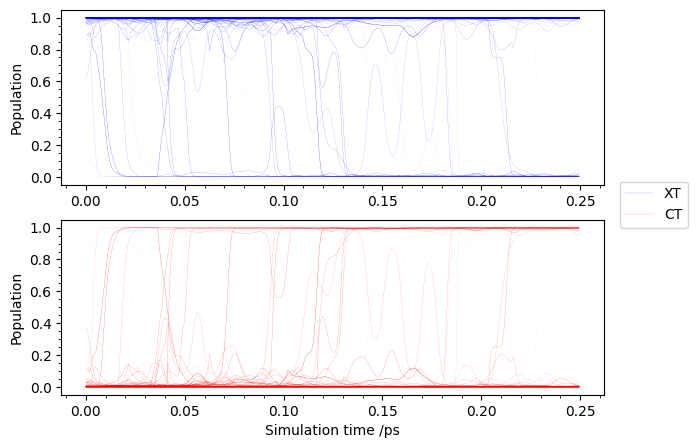

In [ ]:
XT_fluctuation = find_fluctuations(total_XT_single_populations, 0.05, 0.9)
time_nstep_intervals = np.arange(0, len(total_XT_single_populations[0]))*nuclear_timestep*10/1000

fig, axs = plt.subplots(nrows=2,ncols=1, figsize=(7,5))

for index in range(len(total_XT_single_populations)):

    shading_parameter = 1 - index/len(XT_fluctuation)
    #fluctuation_row = XT_fluctuation[index]

    #if XT_fluctuation[index][2] != 0:

     #   traj_index = int(fluctuation_row[0])
     #   dissociation_index = int(fluctuation_row[1])
     #   comeback_index = int(fluctuation_row[2])
    if index == 0:
        axs[0].plot(time_nstep_intervals[:500], total_XT_single_populations[index][:500], color = 'b', alpha = shading_parameter, linewidth=0.1, label = 'XT')
        axs[1].plot(time_nstep_intervals[:500], total_CT_single_populations[index][:500], color = 'r', alpha = shading_parameter, linewidth=0.1, label = 'CT')
    else:
        axs[0].plot(time_nstep_intervals[:500], total_XT_single_populations[index][:500], color = 'b', alpha = shading_parameter, linewidth=0.1)
        axs[1].plot(time_nstep_intervals[:500], total_CT_single_populations[index][:500], color = 'r', alpha = shading_parameter, linewidth=0.1)
        #plt.scatter(time_nstep_intervals[dissociation_index], total_XT_single_populations[traj_index][dissociation_index], color = 'k', s = 20)
        #plt.scatter(time_nstep_intervals[comeback_index], total_XT_single_populations[traj_index][comeback_index], color = 'r', s = 20)

#plt.title('Individual exciton population')
#plt.ylabel('Population')
#plt.xlabel('Simulation time /fs')
axs[1].set_xlabel('Simulation time /ps')
axs[1].set_ylabel('Population')
axs[0].set_ylabel('Population')
axs[0].minorticks_on()
axs[1].minorticks_on()
fig.legend(bbox_to_anchor=(1.03, 0.55))

(0.0, 5.0)

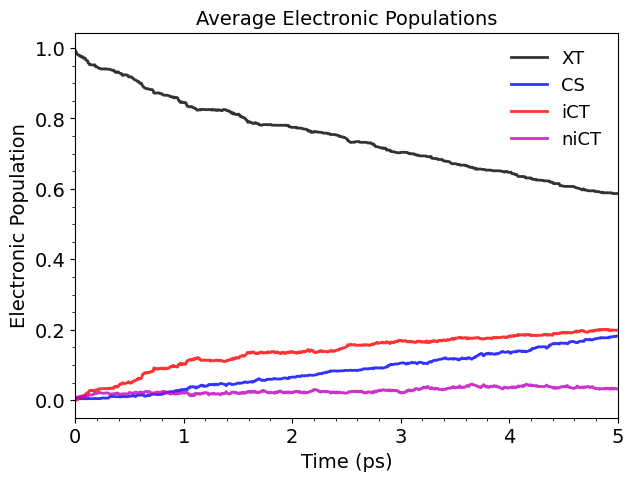

In [ ]:
avg_CSS_population, CSS_population_sd = block_statistics(CSS_single_populations, 5)
avg_XT_population, XT_population_sd = block_statistics(total_XT_single_populations, 5)
avg_INT_population, INT_population_sd = block_statistics(INT_single_populations, 5)
avg_CT_population, CT_population_sd = block_statistics(CT_single_populations, 5)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))

ax.plot(time_nstep_intervals, avg_XT_population, color = 'k', label = 'XT', linewidth=2, alpha=0.8)
ax.plot(time_nstep_intervals, avg_CSS_population, color = 'b', label = 'CS', linewidth=2, alpha=0.8)
ax.plot(time_nstep_intervals, avg_INT_population, color = 'r', label = 'iCT', linewidth=2, alpha=0.8)
ax.plot(time_nstep_intervals, avg_CT_population, color = 'm', label = 'niCT', linewidth=2, alpha=0.8)
#ax.plot(time_nstep_intervals, avg_CSS_population+avg_CT_population+avg_INT_population+avg_XT_population, color='gray', label='Total')
ax.set_ylabel('Electronic Population', fontsize=14)
ax.set_title('Average Electronic Populations', fontsize=14)
ax.set_xlabel('Time (ps)', fontsize=14)
ax.legend(fontsize=13, frameon=False)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
ax.minorticks_on()
ax.set_xlim([0,5])

In [9]:
exciton_single_IPR = np.loadtxt(analysis_path_optical + f'/{file_tag}_individual_exciton_IPR.txt')
electron_single_IPR = np.loadtxt(analysis_path_optical + f'/{file_tag}_individual_electron_IPR.txt')
hole_single_IPR = np.loadtxt(analysis_path_optical + f'/{file_tag}_individual_hole_IPR.txt')

exciton_single_locations = np.loadtxt(analysis_path_optical + f'/{file_tag}_individual_exciton_locations.txt')
electron_single_locations = np.loadtxt(analysis_path_optical + f'/{file_tag}_individual_electron_locations.txt')
hole_single_locations = np.loadtxt(analysis_path_optical + f'/{file_tag}_individual_hole_locations.txt')

In [53]:
CSS_indices = np.where(CSS_single_populations > 0.8)

CSS_hole_IPR = hole_single_IPR[CSS_indices[0], CSS_indices[1]]
CSS_electron_IPR = electron_single_IPR[CSS_indices[0], CSS_indices[1]]
CSS_pops = CSS_single_populations[CSS_indices[0], CSS_indices[1]]

mean_CSS_hole_IPR = np.mean(CSS_hole_IPR)
mean_CSS_electron_IPR = np.mean(CSS_electron_IPR)

print(mean_CSS_hole_IPR)
print(mean_CSS_electron_IPR)

2.246343161306156
2.8023606344382026


In [54]:
def bin_carrier_locations(wf_indices, individual_carrier_locations):

    number_instances = len(wf_indices[0])
    carrier_location_list = []

    for instance in range(number_instances):

        column = wf_indices[1][instance]
        row = wf_indices[0][instance]

        carrier_location = individual_carrier_locations[row,column]
        carrier_location_list.append(carrier_location)

    return np.array(carrier_location_list)

In [ ]:
number_trajectories = len(CSS_single_populations)
all_pathways = []
#defining list that will contain the pathways of all trajectories

XT_CT_threshold = 0.95
CSS_iCT_theshold = 0.8

for index in range(0,number_trajectories):

    pathway = []
    condensed_pathway = []

    for frame in range(len(avg_CSS_population)): #truncating to 20000 steps (10ps)

        #for each printed timestep in the simulation, we categorise the wvaefunction into different types of electronic state,
        #depending on which type of diabat dominates the electronic wavefunction

        if CSS_single_populations[index][frame] > CSS_iCT_theshold:
            pathway.append('CSS')
            #e.g. if CSS diabats make up 80% of the wavefunction, then we label this timestep 'CSS', and we do this
            #for the other diabat types

        elif (INT_single_populations[index][frame]) > CSS_iCT_theshold:
            pathway.append('iCT')
        elif total_CT_single_populations[index][frame] > XT_CT_threshold:
            pathway.append('CT')
        elif total_XT_single_populations[index][frame] > XT_CT_threshold:
            pathway.append('XT')

        else:

            pathway.append('H')
            #if neither CT not XT-states generally dominate the wavefunction, then we assign it as a hybrid state
            
         #   if total_XT_single_populations[index][frame] > population_threshold:
         #       pathway.append('hXT')

         #   elif total_CT_single_populations[index][frame] > population_threshold:
         #       pathway.append('hCT')

         #  else:
         #      pathway.append('H')

    condensed_pathway.append(pathway[0])
    for index2 in range(1, len(pathway)):
        #printing each timestep's wavefunction character is too complicated, so we just print the instances where they
        #change, to see how the carriers change throughout the simulation
        
        if pathway[index2] != pathway[index2 - 1]:
            condensed_pathway.append(pathway[index2])

    all_pathways.append(condensed_pathway)
    #then append this abridged pathway to the list of all trajectories' pathways

#many of these trajectories actually oscillate between two state types before doing anything. We want to simplify this so
#it is easy to categorise the different pathways. Currently, a pathway that decays to iCT through XT --> H will be unique from
#all other instances if it flits between XT and H an arbitrary number of times, but we mostly care about how the exciton dissociates
    
#fluctuation_counter = 0
for index3 in range(len(all_pathways)):

    p = all_pathways[index3]
    fluctuation_keyword = False

    if (p.count('XT') > 1):
        #remove XT oscillating with other states before dissociating

        reversed_p = list(reversed(p))
        reversed_XT_index = reversed_p.index('XT')
        #find final occurence of XT

        final_XT_index = -reversed_XT_index - 1
        abridged_p = p[final_XT_index:]
        leftover_p = p[:final_XT_index]

        #if (leftover_p.count('iCT') > 0):
        #    fluctuation_counter += 1
        #    abridged_p = ['XT','H','iCT','H'] + abridged_p
        #    fluctuation_keyword = True

        #elif (leftover_p.count('CT') > 0):
        #    fluctuation_counter += 1
        #    abridged_p = ['XT','H','CT','H'] + abridged_p
        #    fluctuation_keyword = True

        p = abridged_p[:]

        #remove all elements before this occurence. Essentially, if a simulation begins in XT, we don't care about anything it
        #does before the exciton irreversibly dissociates

    if p[-1] == 'CSS':
        #remove CSS oscillations with other CT-state types

        CSS_index = p.index('CSS')
        #find first CSS instance

        p = p[:CSS_index+1] #+ [p[-1]]
        #remove all elements after this, we assume all charges are swept away by field once they reach the CSS

    if p[-1] == 'iCT':

        iCT_index = p.index('iCT') #find index of first iCT instance
        p = p[:iCT_index+1] #remove all elements after this to remove irrelevant fluctuations, and we know the traj. ends in the same state

    if p[-1] == 'CT':

        CT_index = p.index('CT')
        p = p[:CT_index+1] #removing all fluctuations after first non-interfacial CT occurrance

    all_pathways[index3] = p

all_pathways = ['-->'.join(p) for p in all_pathways]
#convert all truncated pathways to strings

pathway_types = list(set(all_pathways))
#define new list which contains strings of unique pathways only

pathway_counts = map(lambda x: all_pathways.count(x), pathway_types)
pathway_counts = list(pathway_counts)
#get number of times these unique pathways occur in the trajectory ensemble

pathway_1 = 0 #XT
pathway_2 = 0 #XT -> H -> iCT
pathway_3 = 0 #XT -> H -> CT -> iCT
pathway_4 = 0 #XT -> iCT -> CT
pathway_5 = 0 #XT -> H -> CT
pathway_6 = 0 #XT -> H -> iCT -> CSS
pathway_7 = 0 #XT -> H -> CT -> CSS

for index4 in range(len(pathway_types)):

    pathway_type = pathway_types[index4]
    pathway_count = pathway_counts[index4]

    #ignoring initial XT and then hybrid states to see the relative contribution of each pathway for a given initial state
    #if pathway_type[0:2] != 'XT': continue

    if pathway_type[-3:] == 'CSS':

        if ('iCT' in pathway_type):
            pathway_6 += pathway_count
        else:
            pathway_7 += pathway_count
    
    elif pathway_type[-3:] == '>CT':

        if 'iCT' in pathway_type:
            pathway_4 += pathway_count
        else:
            pathway_5 += pathway_count

    elif pathway_type[-3:] == 'iCT':
        if '>CT' in pathway_type:
            pathway_3 += pathway_count
        else:
            pathway_2 += pathway_count

    else:
        pathway_1 += pathway_count

all_types = np.array([pathway_1, pathway_2, pathway_3, pathway_4, pathway_5, pathway_6, pathway_7])/len(all_pathways)
print(all_types/np.sum(all_types))

[0.37349398 0.19879518 0.02008032 0.00803213 0.01807229 0.17269076
 0.20883534]


In [10]:
physopt = [0.33198381, 0.62753036, 0.03643725, 0.00404858, 0,         0,    0,        ]
e3_2xCT = [0.29959514, 0.00809717, 0.00404858, 0.35425101, 0.25910931, 0.02631579, 0.048583  ]
e3_3xCT = [0.13709677, 0.00403226, 0,         0.14919355 ,0.46169355, 0.04637097, 0.2016129 ]
e5 = [0.31313131, 0.44444444 ,0.13737374, 0.07272727, 0.01010101, 0, 0.02222222]
e5_2xCT = [0.12145749, 0,         0,         0.11133603, 0.43927126 ,0.048583, 0.27935223]
e5_3xCT = [0.10707071, 0,         0,         0.04444444, 0.41010101, 0.01010101, 0.42828283]
e10 = [0.04276986, 0.05498982, 0.12830957, 0.16904277, 0.47454175, 0.04480652, 0.08553971]

decay_pathways_1 = [physopt, e5, e10]
decay_pathways_2 = [physopt, e3_2xCT, e3_3xCT]
decay_pathways_3 = [e5_2xCT, e5, e5_3xCT]

mechanism_indices = np.arange(len(physopt)-1) + 1
mechanisms = ['XT', '1. XT\u2192H\u2192iCT', '2. XT\u2192H\u2192niCT\u2192iCT', '3. XT\u2192H\u2192iCT\u2192niCT', '4. XT\u2192H\u2192niCT', '5. XT\u2192H\u2192iCT\u2192CS', '6. XT\u2192H\u2192niCT\u2192CS']

colours_1 = ['b', 'purple', 'orange']
colours_2 = ['b', 'deepskyblue', 'greenyellow']
colours_3 = ['pink', 'purple', 'crimson']

labels_1 = ['(1)', '(4)' ,'(7)']
labels_2 = ['(1)', '(2)', '(3)']
labels_3 = ['(5)', '(4)', '(6)']

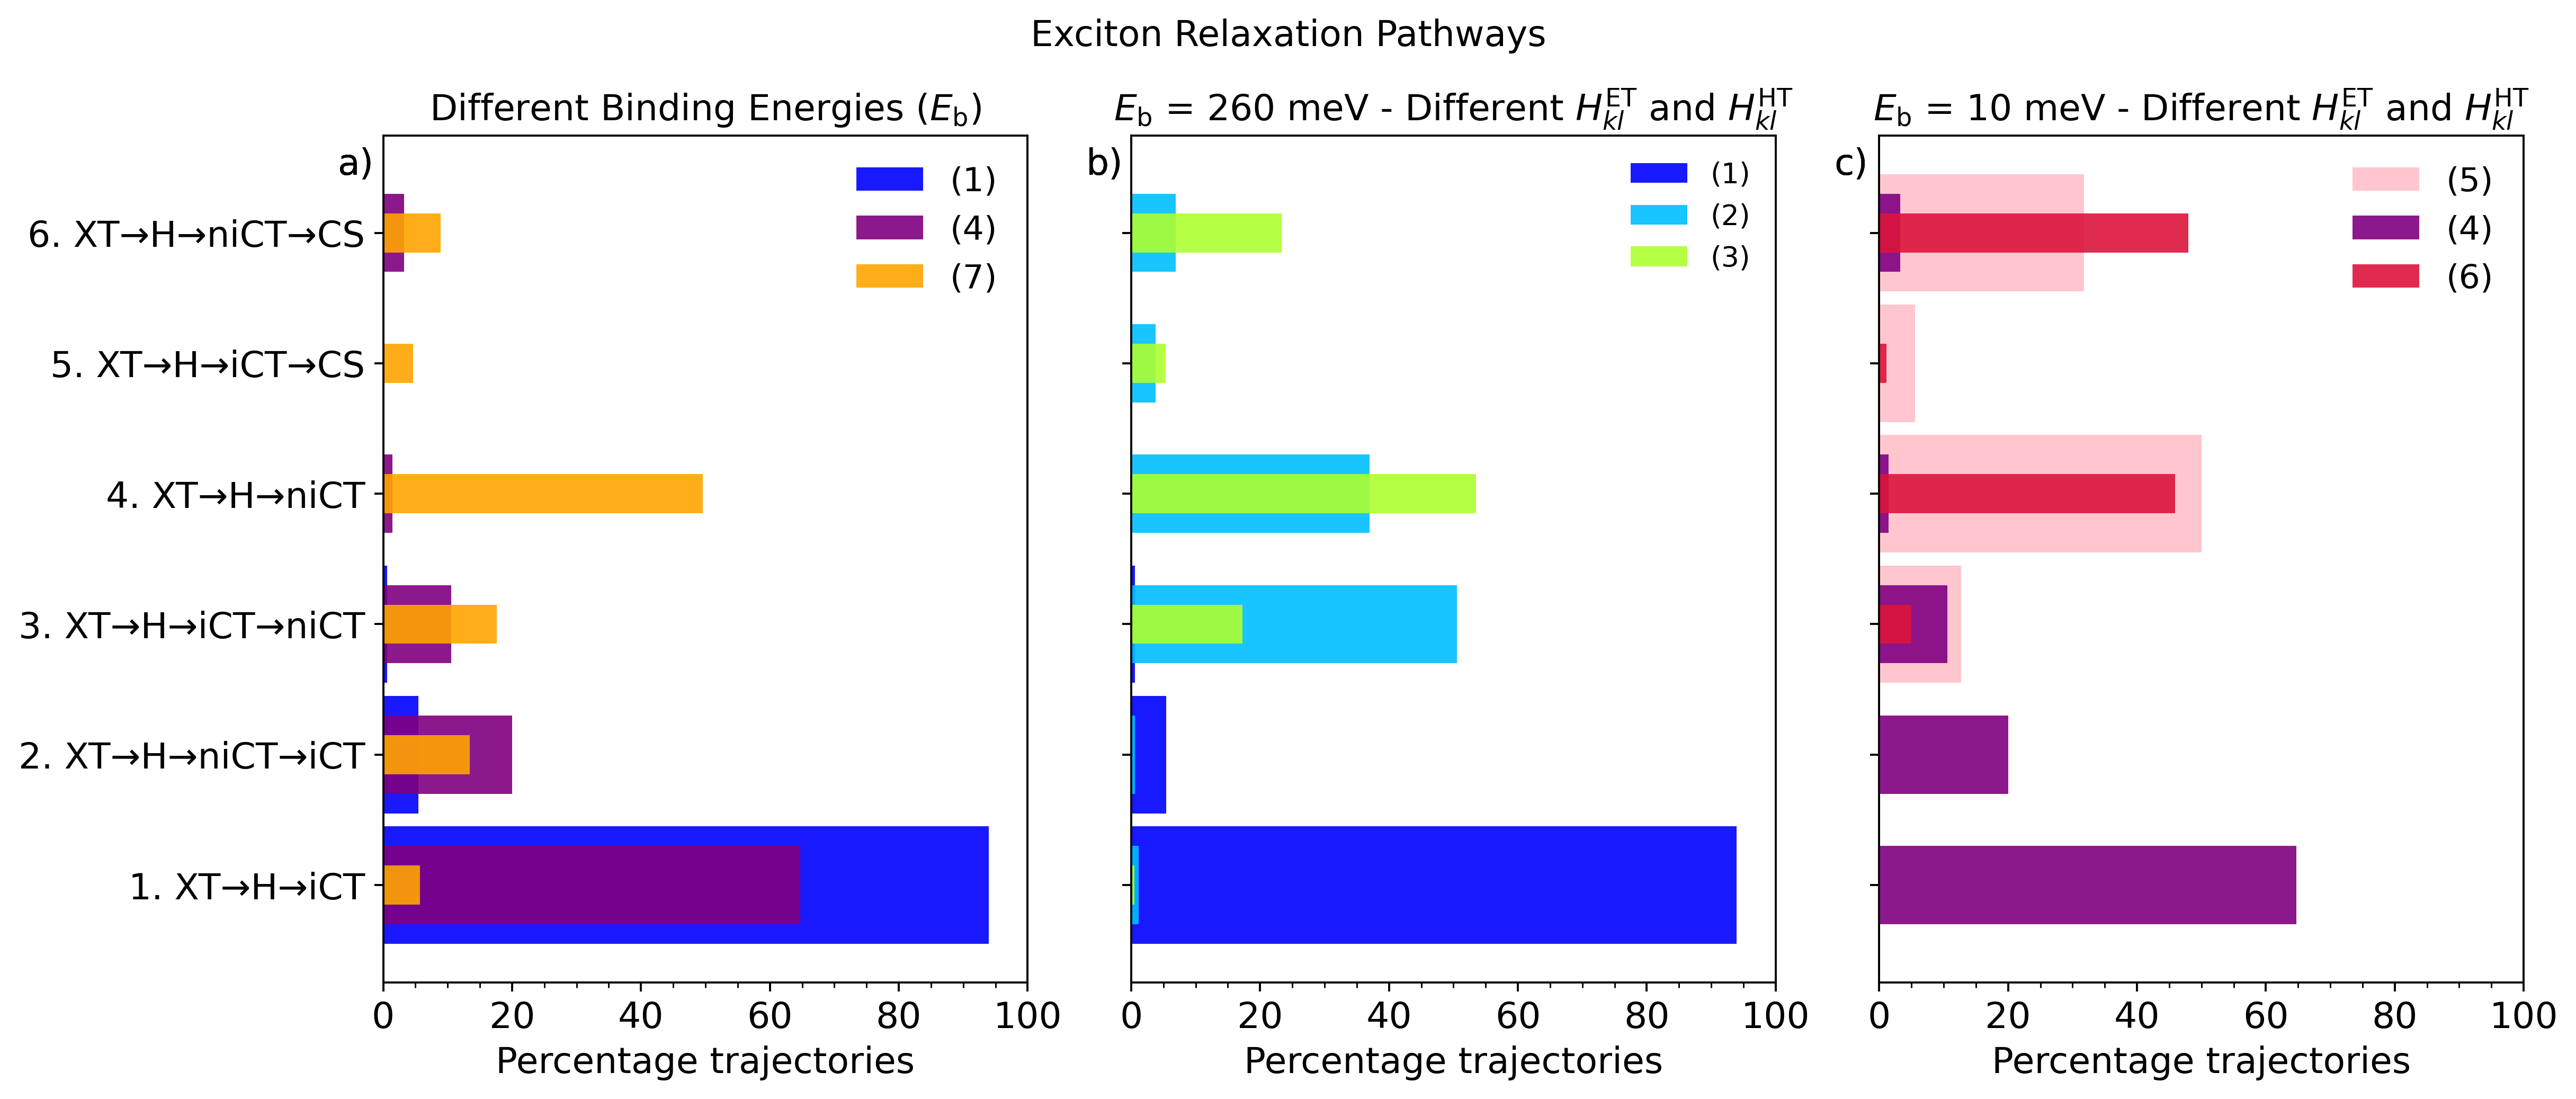

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14,6), rasterized=True, dpi=350)

for index in range(3):


    axs[0].barh(mechanisms[1:], np.array(decay_pathways_1[index][1:])*100/np.sum(decay_pathways_1[index][1:]), color = colours_1[index], alpha = 0.9, height=0.9-index*0.3, label = f'{labels_1[index]}')
    axs[0].yaxis.set_tick_params(labelsize = 14)
    axs[0].xaxis.set_tick_params(labelsize = 14)
    axs[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    #axs[0].legend(bbox_to_anchor = (1,-0.2), fontsize=12)
    axs[0].set_xlim([0,100])
    axs[0].set_xlabel('Percentage trajectories', fontsize=14)
    axs[0].text(-7, 5.45, 'a)', fontsize=14)
    axs[0].set_title('Different Binding Energies ($E_{\mathrm{b}}$)', fontsize=14)
    axs[0].legend(loc='upper right', fontsize=13, frameon=False)

    axs[1].barh(mechanisms[1:], np.array(decay_pathways_2[index][1:])*100/np.sum(decay_pathways_2[index][1:]), color = colours_2[index], alpha = 0.9, height=0.9-index*0.3, label = f'{labels_2[index]}')
    axs[1].xaxis.set_tick_params(labelsize = 14)
    axs[1].legend(bbox_to_anchor = (1,-0.2), fontsize=13)
    axs[1].set_xlim([0,100])
    axs[1].set_xlabel('Percentage trajectories', fontsize=14)
    axs[1].text(-7, 5.45, 'b)', fontsize=14)
    axs[1].set_title(r'$E_\mathrm{b}$ = 260 meV - Different $H^{\mathrm{ET}}_{kl}$ and $H^{\mathrm{HT}}_{kl}$', fontsize=14)
    axs[1].legend(loc='upper right', fontsize=11, frameon=False)
    axs[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())

    axs[2].barh(mechanisms[1:], np.array(decay_pathways_3[index][1:])*100/np.sum(decay_pathways_3[index][1:]), color = colours_3[index], alpha = 0.9, height=0.9-index*0.3, label = f'{labels_3[index]}')
    axs[2].xaxis.set_tick_params(labelsize = 14)
    axs[2].legend(bbox_to_anchor = (1,-0.2), fontsize=12)
    axs[2].set_xlim([0,100])
    axs[2].set_xlabel('Percentage trajectories', fontsize=14)
    axs[2].text(-7, 5.45, 'c)', fontsize=14)
    axs[2].set_title(r'$E_\mathrm{b}$ = 10 meV - Different $H^{\mathrm{ET}}_{kl}$ and $H^{\mathrm{HT}}_{kl}$', fontsize=14)
    axs[2].legend(loc='upper right', fontsize=13, frameon=False)
    axs[2].xaxis.set_minor_locator(ticker.AutoMinorLocator())


fig.suptitle('Exciton Relaxation Pathways', fontsize=14)
fig.tight_layout()

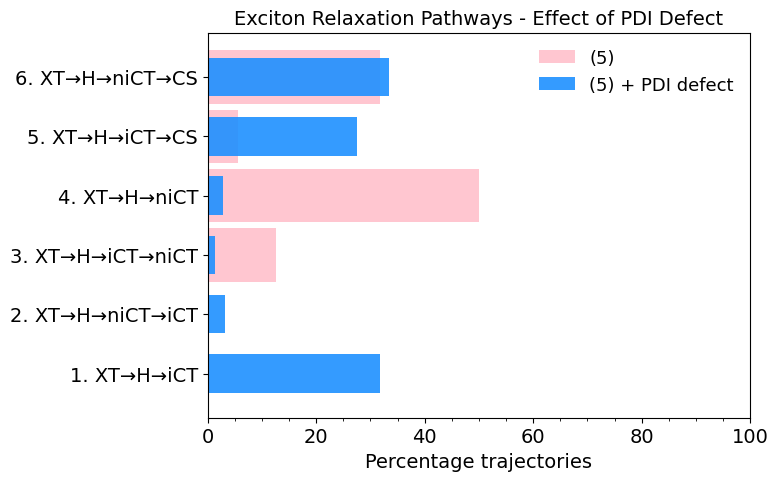

In [9]:
e5_2xCT_defect = [0.37349398, 0.19879518, 0.02008032, 0.00803213, 0.01807229, 0.17269076, 0.20883534]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.barh(mechanisms[1:], np.array(e5_2xCT[1:])*100/np.sum(e5_2xCT[1:]), color = 'pink', alpha = 0.9, height=0.9, label = '(5)')
ax.barh(mechanisms[1:], np.array(e5_2xCT_defect[1:])*100/np.sum(e5_2xCT_defect[1:]), color = 'dodgerblue', alpha = 0.9, height=0.65, label = '(5) + PDI defect')
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlim([0,100])
ax.set_xlabel('Percentage trajectories', fontsize=14)
#ax.text(-7, 5.45, 'a)', fontsize=14)
ax.set_title('Exciton Relaxation Pathways - Effect of PDI Defect', fontsize=14)
ax.legend(loc='upper right', fontsize=13, frameon=False)

In [59]:
'''
diabatic_loc = np.mean(exciton_single_locations_diab, axis=0) - 92
diabatic_sd = np.std(exciton_single_locations_diab, axis=0)

adiabatic_loc = np.mean(exciton_single_locations, axis=0) - 92
adiabatic_sd = np.std(exciton_single_locations, axis=0)

plt.plot(np.arange(len(avg_XT_population_diab))*0.5/1000, diabatic_loc, color='purple', label='Diabatic')
plt.fill_between(np.arange(len(avg_XT_population_diab))*0.5/1000, diabatic_loc - diabatic_sd, diabatic_loc + diabatic_sd, alpha=0.4, color='purple')
plt.plot(np.arange(len(avg_XT_population_diab))*0.5/1000, adiabatic_loc, color='orange', label='Adiabatic')
plt.fill_between(np.arange(len(avg_XT_population_diab))*0.5/1000, adiabatic_loc - adiabatic_sd, adiabatic_loc + adiabatic_sd, alpha=0.4, color='orange')
plt.ylabel('Exciton Distance (\u212B)')
plt.xlabel('Time (ps)')
plt.legend(frameon=False)
'''

"\ndiabatic_loc = np.mean(exciton_single_locations_diab, axis=0) - 92\ndiabatic_sd = np.std(exciton_single_locations_diab, axis=0)\n\nadiabatic_loc = np.mean(exciton_single_locations, axis=0) - 92\nadiabatic_sd = np.std(exciton_single_locations, axis=0)\n\nplt.plot(np.arange(len(avg_XT_population_diab))*0.5/1000, diabatic_loc, color='purple', label='Diabatic')\nplt.fill_between(np.arange(len(avg_XT_population_diab))*0.5/1000, diabatic_loc - diabatic_sd, diabatic_loc + diabatic_sd, alpha=0.4, color='purple')\nplt.plot(np.arange(len(avg_XT_population_diab))*0.5/1000, adiabatic_loc, color='orange', label='Adiabatic')\nplt.fill_between(np.arange(len(avg_XT_population_diab))*0.5/1000, adiabatic_loc - adiabatic_sd, adiabatic_loc + adiabatic_sd, alpha=0.4, color='orange')\nplt.ylabel('Exciton Distance (Å)')\nplt.xlabel('Time (ps)')\nplt.legend(frameon=False)\n"

In [60]:
'''
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,6))

axs[0].hist(exciton_single_locations[np.where(total_XT_single_populations[:,2000]>0.95)[0],2000] - 92, color='orange', label='Adiabatic', bins=20)
axs[0].hist(exciton_single_locations_diab[np.where(total_XT_single_populations_diab[:,2000]>0.95)[0],2000] - 92, color='purple', label='Diabatic', bins=20, rwidth=0.75)
axs[0].set_title('Exciton Distance Distribution - 1ps')
axs[0].legend(frameon=False)

axs[1].hist(exciton_single_locations[np.where(total_XT_single_populations[:,4000]>0.95)[0],4000] - 92, color='orange', label='Adiabatic', bins=20)
axs[1].hist(exciton_single_locations_diab[np.where(total_XT_single_populations_diab[:,4000]>0.95)[0],4000] - 92, color='purple', label='Diabatic', bins=20, rwidth=0.75)
axs[1].set_title('Exciton Distance Distribution - 2ps')

axs[2].hist(exciton_single_locations[np.where(total_XT_single_populations[:,8000]>0.95)[0],8000] - 92, color='orange', label='Adiabatic', bins=20)
axs[2].hist(exciton_single_locations_diab[np.where(total_XT_single_populations_diab[:,8000]>0.95)[0],8000] - 92, color='purple', label='Diabatic', bins=20, rwidth=0.75)
axs[2].set_title('Exciton Distance Distribution - 4ps')

fig.supylabel('No. Trajectories')
fig.supxlabel('Exciton Distance (\u212B)')
fig.tight_layout()
'''

"\nfig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,6))\n\naxs[0].hist(exciton_single_locations[np.where(total_XT_single_populations[:,2000]>0.95)[0],2000] - 92, color='orange', label='Adiabatic', bins=20)\naxs[0].hist(exciton_single_locations_diab[np.where(total_XT_single_populations_diab[:,2000]>0.95)[0],2000] - 92, color='purple', label='Diabatic', bins=20, rwidth=0.75)\naxs[0].set_title('Exciton Distance Distribution - 1ps')\naxs[0].legend(frameon=False)\n\naxs[1].hist(exciton_single_locations[np.where(total_XT_single_populations[:,4000]>0.95)[0],4000] - 92, color='orange', label='Adiabatic', bins=20)\naxs[1].hist(exciton_single_locations_diab[np.where(total_XT_single_populations_diab[:,4000]>0.95)[0],4000] - 92, color='purple', label='Diabatic', bins=20, rwidth=0.75)\naxs[1].set_title('Exciton Distance Distribution - 2ps')\n\naxs[2].hist(exciton_single_locations[np.where(total_XT_single_populations[:,8000]>0.95)[0],8000] - 92, color='orange', label='Adiabatic', bins=20)\naxs[2

In [61]:
def load_electronic_populations(path, file_stems, marker):
    '''
    Function that loads a series of electronic populations, given the path to the directory with the array, the stem of the file name, and then
    the piece of the file name that makes it different from the rest.
    '''

    result_list = []
    filenames = [(file_stem + f'-{marker}') for file_stem in file_stems]
    #re-building the filenames from the different file stems and chosen marker

    for word in filenames:

        loaded_population = np.loadtxt(f'{path}' + f'/{word}')
        #use the filename to load the population from the array
        result_list.append(loaded_population)
        #append the loaded array to a list

    remaining_population = 1 - sum(result_list)
    result_list.append(remaining_population)

    return result_list

In [62]:
def create_population_subplot(axes_object, x_values, population_list, labels, colours, shading_parameters):
    '''
    Function that creates a plot on a single axis object, which is part of a subplot of several axis objects
    '''

    for index in range(len(population_list)):
        axes_object.plot(x_values, population_list[index], label = labels[index], color = colours[index], alpha = shading_parameters[index])

In [63]:
#file_stems = ['physopt_CSS_avg_pops', 'physopt_XT_avg_pops', 'physopt_INT_avg_pops', 'physopt_A_INT_avg_pops']
#file_stems = ['physopt_CSS_avg_pops-IPR', 'physopt_XT_avg_pops-IPR', 'physopt_INT_avg_pops-IPR', 'physopt_A_INT_avg_pops-IPR']
file_stems = ['physopt_CSS_avg_pops-XTloc', 'physopt_XT_avg_pops-XTloc', 'physopt_INT_avg_pops-XTloc']

avg_populations_1 = load_electronic_populations(analysis_path_optical, file_stems, marker=10.20318798)
avg_populations_2 = load_electronic_populations(analysis_path_optical, file_stems, marker=24.6883586)
avg_populations_3 = load_electronic_populations(analysis_path_optical, file_stems, marker=44.17841333)
avg_populations_4 = load_electronic_populations(analysis_path_optical, file_stems, marker=63.57078612)
avg_populations_5 = load_electronic_populations(analysis_path_optical, file_stems, marker=78.17729209)
avg_populations_6 = load_electronic_populations(analysis_path_optical, file_stems, marker=92.73139401)

FileNotFoundError: /scratch/fivanovic/X-SH/T6-PDI/production_runs/epsilon5_2xCTcoup/analysis_arrays/physopt_CSS_avg_pops-XTloc-10.20318798 not found.

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey = True, figsize = (11.5,6.2))

labels = ['Charge-separated', 'Exciton', 'Interfacial CT', 'Non-interfacial CT']
colours = ['b', 'k', 'r', 'm']
shading_parameters = [1, 1, 1, 0.65]

create_population_subplot(ax[0,0], np.arange(0, len(avg_populations_1[0]))*nuclear_timestep*10/1000, avg_populations_1, labels, colours, shading_parameters)
ax[0,0].set_title('0-10 \u212B | 25 Trajectories')
ax[0,0].minorticks_on()
ax[0,0].xaxis.set_tick_params(labelsize = 14)
ax[0,0].yaxis.set_tick_params(labelsize = 14)

create_population_subplot(ax[0,1], np.arange(0, len(avg_populations_2[0]))*nuclear_timestep*10/1000, avg_populations_2, labels, colours, shading_parameters)
ax[0,1].set_title('10-25 \u212B | 90 Trajectories')
ax[0,1].minorticks_on()
ax[0,1].xaxis.set_tick_params(labelsize = 14)
ax[0,1].yaxis.set_tick_params(labelsize = 14)

create_population_subplot(ax[0,2], np.arange(0, len(avg_populations_3[0]))*nuclear_timestep*10/1000, avg_populations_3, labels, colours, shading_parameters)
ax[0,2].set_title('25-44 \u212B | 104 Trajectories')
ax[0,2].legend(bbox_to_anchor=(1.1,0.7), fontsize = 12)
ax[0,2].minorticks_on()
ax[0,2].xaxis.set_tick_params(labelsize = 14)
ax[0,2].yaxis.set_tick_params(labelsize = 14)

create_population_subplot(ax[1,0], np.arange(0, len(avg_populations_4[0]))*nuclear_timestep*10/1000, avg_populations_4, labels, colours, shading_parameters)
ax[1,0].set_title('44-64 \u212B | 96 Trajectories')
ax[1,0].minorticks_on()
ax[1,0].xaxis.set_tick_params(labelsize = 14)
ax[1,0].yaxis.set_tick_params(labelsize = 14)

create_population_subplot(ax[1,1], np.arange(0, len(avg_populations_5[0]))*nuclear_timestep*10/1000, avg_populations_5, labels, colours, shading_parameters)
ax[1,1].set_title('64-78 \u212B | 100 Trajectories')
ax[1,1].minorticks_on()
ax[1,1].xaxis.set_tick_params(labelsize = 14)
ax[1,1].yaxis.set_tick_params(labelsize = 14)

create_population_subplot(ax[1,2], np.arange(0, len(avg_populations_6[0]))*nuclear_timestep*10/1000, avg_populations_6, labels, colours, shading_parameters)
ax[1,2].set_title('78-93 \u212B | 67 Trajectories')
ax[1,2].minorticks_on()
ax[1,2].xaxis.set_tick_params(labelsize = 14)
ax[1,2].yaxis.set_tick_params(labelsize = 14)

fig.supylabel('Electronic Populations', fontsize = 14)
fig.supxlabel('Simulation Time /ps', fontsize = 14)

#ax[0,1].axis('off')
#ax[0,0].axis('off')
#fig.suptitle('Population plots for different initial exciton IPR')